In [1]:
import pandas as pd
import numpy as np

#Imports to enable visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Python standard libraries
import glob, os    
import datetime

In [2]:
#Functions

def read_df_from_csv_folder(folderpath,filename_pattern):
    result = pd.DataFrame()
    files_to_be_read = glob.glob(os.path.join(folderpath, filename_pattern))
    for i in xrange(len(files_to_be_read)):
        try:
            df = pd.read_csv(files_to_be_read[i])
            result = result.append(df)
        except Exception as e:
            pass
    return result


### Read Data

In [3]:
base_folderpath = '/local/tarciso/masters/data/trips-optimality-exp/overall_result/'

#### Trips Improvement Capacity Data

In [4]:
imp_cap_df_raw = read_df_from_csv_folder(base_folderpath + '/duration_improvement_capacity/', 'part-*.csv')
#imp_cap_df = pd.read_csv(base_folderpath + '/result.csv')

In [48]:
imp_cap_df = imp_cap_df_raw

In [49]:
imp_cap_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34223 entries, 0 to 5
Data columns (total 14 columns):
date                  34223 non-null object
user_trip_id          34223 non-null int64
cardNum               34223 non-null int64
birthdate             10006 non-null object
gender                10006 non-null object
exec_start_time       34223 non-null object
executed_duration     34223 non-null float64
itinerary_id          34223 non-null int64
duration              34223 non-null float64
alt_start_time        34223 non-null object
imp_capacity          34223 non-null float64
imp_capacity_perc     34223 non-null float64
trip_length_bucket    34223 non-null object
hour_of_day           34223 non-null int64
dtypes: float64(4), int64(4), object(6)
memory usage: 3.9+ MB


In [50]:
imp_cap_df.head()

,date,user_trip_id,cardNum,birthdate,gender,exec_start_time,executed_duration,itinerary_id,duration,alt_start_time,imp_capacity,imp_capacity_perc,trip_length_bucket,hour_of_day
0,2017-06-28,17179869231,3799263,NaN,NaN,2017-06-28 18:13:56,41.033333,0,41.033333,2017-06-28 18:13:56,0.000000,0.000000,40+,18
1,2017-06-28,128849018982,3733976,NaN,NaN,2017-06-28 12:00:33,687.683333,0,687.683333,2017-06-28 12:00:33,0.000000,0.000000,40+,12
2,2017-06-28,309237645442,3270966,NaN,NaN,2017-06-28 07:39:40,30.333333,0,30.333333,2017-06-28 07:39:40,0.000000,0.000000,30-40,7
3,2017-06-28,352187318396,3399915,27/07/94,F,2017-06-28 18:05:45,88.600000,0,88.600000,2017-06-28 18:05:45,0.000000,0.000000,40+,18
4,2017-06-28,377957122151,2894142,NaN,NaN,2017-06-28 10:46:11,191.966667,3,4.400000,2017-06-28 11:04:35,187.566667,97.707935,40+,10


#### Proportion of Trips with Positive Improvement Capacity Before Filtering

In [51]:
imp_cap_df[imp_cap_df['imp_capacity'] > 0].count()[0]/float(imp_cap_df.count()[0])

0.36989743739590336

### Preparing Data

#### Computing Improvement Capacity as a Percentage to avoid value magnitude bias

In [52]:
imp_cap_df['imp_capacity_perc'] = 100*(imp_cap_df['imp_capacity'] / imp_cap_df['executed_duration'])

In [53]:
imp_cap_df['improved'] = imp_cap_df['imp_capacity_perc'] > 0.0

#### Computing trip length bucket for each trip

In [54]:
def get_trip_len_bucket(trip_duration):
    if (trip_duration < 10):
        return '<10'
    elif (trip_duration < 20):
        return '10-20'
    elif (trip_duration < 30):
        return '20-30'
    elif (trip_duration < 40):
        return '30-40'
    elif (trip_duration < 50):
        return '40-50'
    elif (trip_duration >= 50):
        return '50+'
    else:
        return 'NA'


imp_cap_df['trip_length_bucket'] = imp_cap_df['executed_duration'].apply(get_trip_len_bucket)

#### Computing hour of day and period of day for each trip

In [55]:
imp_cap_df['hour_of_day'] = pd.to_datetime(imp_cap_df['exec_start_time'], format='%Y-%m-%d %H:%M:%S').dt.hour

In [56]:
period_of_day_list = [('hour_of_day', [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]),
         ('period_of_day', ['very_late_night','very_late_night','very_late_night','very_late_night','early_morning','early_morning','early_morning','morning','morning','morning','morning','midday','midday','midday','afternoon','afternoon','afternoon','evening','evening','evening','night','night','late_night','late_night'])]
period_of_day_df = pd.DataFrame.from_items(period_of_day_list)
period_of_day_df.period_of_day = period_of_day_df.period_of_day.astype('category', ordered=True)

period_of_day_df

imp_cap_df = imp_cap_df.merge(period_of_day_df, how='inner', on='hour_of_day')

In [57]:
imp_cap_df.head(10)

,date,user_trip_id,cardNum,birthdate,gender,exec_start_time,executed_duration,itinerary_id,duration,alt_start_time,imp_capacity,imp_capacity_perc,trip_length_bucket,hour_of_day,improved,period_of_day
0,2017-06-28,17179869231,3799263,NaN,NaN,2017-06-28 18:13:56,41.033333,0,41.033333,2017-06-28 18:13:56,0.00,0.000000,40-50,18,False,evening
1,2017-06-28,352187318396,3399915,27/07/94,F,2017-06-28 18:05:45,88.600000,0,88.600000,2017-06-28 18:05:45,0.00,0.000000,50+,18,False,evening
2,2017-06-28,1022202216463,2846721,NaN,NaN,2017-06-28 18:54:44,93.316667,0,93.316667,2017-06-28 18:54:44,0.00,0.000000,50+,18,False,evening
3,2017-06-27,120259084381,3770454,NaN,NaN,2017-06-27 18:06:36,70.833333,2,2.233333,2017-06-27 18:02:06,68.60,96.847059,50+,18,True,evening
4,2017-06-27,274877906968,3837677,NaN,NaN,2017-06-27 18:00:04,126.650000,0,126.650000,2017-06-27 18:00:04,0.00,0.000000,50+,18,False,evening
5,2017-06-27,1262720385094,3350216,08/05/89,M,2017-06-27 18:14:15,26.216667,2,7.866667,2017-06-27 18:13:42,18.35,69.993643,20-30,18,True,evening
6,2017-06-27,8589934677,2717024,NaN,NaN,2017-06-27 18:07:24,196.583333,3,2.683333,2017-06-27 18:14:54,193.90,98.635015,50+,18,True,evening
7,2017-06-21,171798691854,3270046,NaN,NaN,2017-06-21 18:01:03,5.016667,0,5.016667,2017-06-21 18:01:03,0.00,0.000000,<10,18,False,evening
8,2017-06-21,721554505846,2999063,03/02/63,F,2017-06-21 18:48:16,2.000000,0,2.000000,2017-06-21 18:48:16,0.00,0.000000,<10,18,False,evening
9,2017-06-21,970662609072,2974189,NaN,NaN,2017-06-21 18:33:20,36.016667,0,36.016667,2017-06-21 18:33:20,0.00,0.000000,30-40,18,False,evening


#### Filtering trips that are too short or too long

In [58]:
min_trip_dur = 10
max_trip_dur = 50

clean_trips = imp_cap_df[(imp_cap_df['executed_duration'] >= min_trip_dur) & (imp_cap_df['executed_duration'] < max_trip_dur)]

In [59]:
clean_trips.count()[0]

11207

#### Computing How many trips can be improved after filtering by trip length

In [60]:
sum(clean_trips['improved'])/float(clean_trips.count()[0])

0.34835370750423844

#### Number of Trips with/without improvent per Trip Length Bucket

In [61]:
trips_per_length = clean_trips.groupby('trip_length_bucket').size().reset_index(name='total')

In [62]:
trips_per_length

,trip_length_bucket,total
0,10-20,3947
1,20-30,3053
2,30-40,2357
3,40-50,1850


In [63]:
trips_per_length_improved = clean_trips[clean_trips['improved']].groupby('trip_length_bucket').size().reset_index(name='total')

In [64]:
trips_per_length_improved

,trip_length_bucket,total
0,10-20,1109
1,20-30,1032
2,30-40,895
3,40-50,868


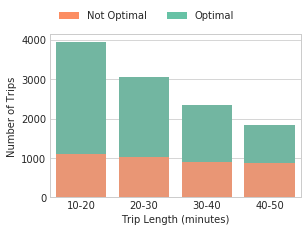

In [65]:
sns.set_style("whitegrid")

#Plot 1 - background - "total" (top) series
ax = sns.barplot(x = trips_per_length.trip_length_bucket, y = trips_per_length.total, color = "#66c2a5")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = trips_per_length_improved.trip_length_bucket, y = trips_per_length_improved.total, color = "#fc8d62")

bottom_plot.set(xlabel='Trip Length (minutes)',ylabel='Number of Trips')

topbar = plt.Rectangle((0,0),1,1,fc="#66c2a5", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#fc8d62',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Not Optimal', 'Optimal'], bbox_to_anchor=(0, 1.2), loc=2, ncol = 2, prop={'size':10})
l.draw_frame(False)

fig = ax.get_figure()
fig.set_size_inches(4.5, 3)
fig.savefig('/local/tarciso/masters/data/results/trip_length_by_optimality.pdf', bbox_inches='tight')

### Analyzing Data Distribution

In [68]:
pos_improvement = clean_trips[(clean_trips['imp_capacity'] > 0) & (clean_trips['duration'] >= 10)]

In [69]:
pos_improvement.count()[0]

1878

### Improvement Capacity Percentage

#### Overall

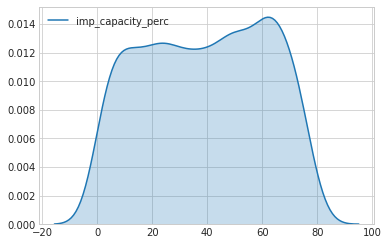

In [70]:
sns.kdeplot(pos_improvement.imp_capacity_perc, shade=True)

In [71]:
pos_improvement.imp_capacity_perc.describe()

count    1878.000000
mean       39.234768
std        22.291753
min         0.132890
25%        20.104908
50%        40.012443
75%        59.236755
max        79.461279
Name: imp_capacity_perc, dtype: float64

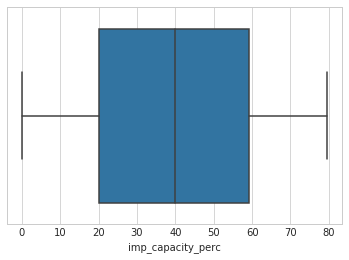

In [72]:
sns.boxplot(x=pos_improvement.imp_capacity_perc)

#### Per trip length 

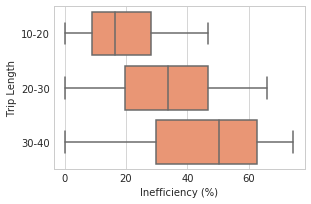

In [75]:
#trip_len_order=['0-15','15-30','30-45','45+']
trip_len_order=['10-20','20-30','30-40']
ax = sns.boxplot(x='imp_capacity_perc',y='trip_length_bucket', orient='h', data=pos_improvement, order=trip_len_order, color='#fc8d62')
ax.set(xlabel='Inefficiency (%)',ylabel='Trip Length')

fig = ax.get_figure()
fig.set_size_inches(4.5, 3)
fig.savefig('/local/tarciso/masters/data/results/imp_capacity_per_trip_length.pdf', bbox_inches='tight')

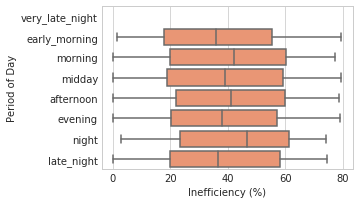

In [76]:
period_of_day_order = ['very_late_night','early_morning','morning','midday','afternoon','evening','night','late_night']
ax = sns.boxplot(x='imp_capacity_perc',y='period_of_day', data=pos_improvement, order=period_of_day_order, color='#fc8d62')
ax.set(xlabel='Inefficiency (%)',ylabel='Period of Day')

fig = ax.get_figure()
fig.set_size_inches(4.5, 3)
fig.savefig('/local/tarciso/masters/data/results/imp_capacity_per_day_period.pdf', bbox_inches='tight')

In [ ]:
sns.violinplot(x=pos_improvement[pos_improvement['trip_length_bucket'] == '45+'].executed_duration)

In [ ]:
sns.violinplot(x=pos_improvement[pos_improvement['trip_length_bucket'] == '45+'].duration)

In [ ]:
pos_improvement.sort_values(by='imp_capacity', ascending=False).head(10)

In [ ]:
highest_imp_trip = pos_improvement.sort_values(by='imp_capacity', ascending=False).head(1)

In [ ]:
highest_imp_trip

In [ ]:
od_matrix = read_df_from_csv_folder('/local/tarciso/masters/data/bus_trips/buste-v3a/may_jun_jul/od_days/2017_06_19_od/', 'part-*.csv')

In [ ]:
od_matrix.head()

In [ ]:
od_matrix.columns

In [ ]:
matched_trip = od_matrix.merge(highest_imp_trip, left_on = ['cardNum'], right_on = ['cardNum'])

In [ ]:
matched_trip

In [ ]:
matched_trip[['o_shape_lat','o_shape_lon','o_timestamp','shapeLat','shapeLon','next_o_shape_lat','next_o_shape_lon','next_o_timestamp']]

#### Filtering out trips which improved and best trip alternative was lower than X minutes

In [ ]:
clean_trips = pos_improvement[pos_improvement['imp_capacity_perc'] < 0.5]
#clean_trips = pos_improvement[pos_improvement['duration'] > 10]

In [ ]:
sns.boxplot(clean_trips[clean_trips['trip_length_bucket'] == '45+'].duration)

In [ ]:
clean_trips[clean_trips['trip_length_bucket'] == '45+'].head(20)

In [ ]:
trip_len_order=['0_15','15_30','30_45','45+']
ax = sns.boxplot(x='imp_capacity_perc',y='trip_length_bucket', orient='h', data=clean_trips, order=trip_len_order)
ax.set(xlabel='Trip Length Bucket',ylabel='Improvement Capacity Proportion',title='Improvement Capacity Proportion per Trip Length Bucket')
plt.show()

#### Per hour of day

In [ ]:
ax = sns.violinplot(x='hour_of_day',y='imp_capacity_perc', data=pos_improvement)
ax.set(xlabel='Hour of Day',ylabel='Improvement Capacity Proportion',title='Improvement Capacity Proportion per Hour of Day')
plt.show()

#### Per period of day

In [ ]:
period_of_day_order = ['very_late_night','early_morning','morning','midday','afternoon','early_night','night','late_night']
ax = sns.boxplot(x='imp_capacity_perc',y='period_of_day', data=pos_improvement, order=period_of_day_order, color='#fc8d62')
ax.set(xlabel='Improvement Capacity (%)',ylabel='Period of Day')
plt.show()

#### Per trip length and Period of Day

In [ ]:
col_order = ['very_late_night','early_morning','morning','midday','afternoon','early_night','night','late_night']
sns.factorplot(x='imp_capacity_perc',y='period_of_day',hue='trip_length_bucket', data=pos_improvement, kind='bar', size=6, order=col_order)

#### Per Day of Week (Sun-Sat)

#### Per Day Type (Mon,Fri,Tue-Thu,Sat-Sun)